In [1]:
# Install the pyspark using pip
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=c224282facc974fadd20a61cc06d6de93c741b29d6256402cc8b2d556393bfbc
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
# Install the kaggle library using pip
! pip install kaggle

# Creat a new directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%pylab inline
import plotly.express as px
import time

import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                      NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import regexp_replace, col

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#evaluation and feature engineering
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from datetime import datetime, date
from imblearn.under_sampling import TomekLinks
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,\
                                       NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import regexp_replace, col
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Download the UNSW_NB15 Dataset
!kaggle datasets download -d dhoogla/unswnb15

# Create a new directory inside My Drive
!mkdir -p "/content/drive/My Drive/dhoogla/unswnb15/"
# Copy the 'fraud-detection.zip' file to the 'fraud-detection' directory
!cp unswnb15.zip "/content/drive/My Drive/dhoogla/unswnb15"
# Unzip the bank fraud detection dataset file
!unzip "/content/drive/My Drive/dhoogla/unswnb15/unswnb15.zip"

 43% 5.00M/11.7M [00:00<00:00, 37.1MB/s]
100% 11.7M/11.7M [00:00<00:00, 58.4MB/s]
Archive:  /content/drive/My Drive/dhoogla/unswnb15/unswnb15.zip
  inflating: UNSW_NB15_testing-set.parquet  
  inflating: UNSW_NB15_training-set.parquet  


In [5]:
# Read the UNSW_NB15 Dataset
df = pd.read_parquet('UNSW_NB15_training-set.parquet')
df

# Check the first 5 rows of the dataset
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [6]:
# Check data information for UNSW-NB15 dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                82332 non-null  float32 
 1   proto              82332 non-null  category
 2   service            82332 non-null  category
 3   state              82332 non-null  category
 4   spkts              82332 non-null  int16   
 5   dpkts              82332 non-null  int16   
 6   sbytes             82332 non-null  int32   
 7   dbytes             82332 non-null  int32   
 8   rate               82332 non-null  float32 
 9   sload              82332 non-null  float32 
 10  dload              82332 non-null  float32 
 11  sloss              82332 non-null  int16   
 12  dloss              82332 non-null  int16   
 13  sinpkt             82332 non-null  float32 
 14  dinpkt             82332 non-null  float32 
 15  sjit               82332 non-null  float32 
 16  djit

In [7]:
# Check Summary statistics
df.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,...,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,82410.890625,6.454902e+07,6.305469e+05,4.753692,6.308556,...,116.275069,0.094277,1.595372e+03,4.928898,3.663011,0.008284,0.008381,0.129743,0.011126,0.550600
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,148620.375000,1.798618e+08,2.393000e+06,64.649620,55.708021,...,244.600271,0.542922,3.806697e+04,8.389545,5.915386,0.091171,0.092485,0.638683,0.104891,0.497436
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,28.606114,1.120247e+04,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2650.176758,5.770032e+05,2.112951e+03,1.000000,0.000000,...,44.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,111111.109375,6.514286e+07,1.585808e+04,3.000000,2.000000,...,87.000000,0.000000,0.000000e+00,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1000000.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,...,1500.000000,131.000000,5.242880e+06,59.000000,38.000000,2.000000,2.000000,16.000000,1.000000,1.000000


In [8]:
# Check for missing values in the DataFrame
missing_values = df.isna().sum()
print("Missing values before treatment:")
print(missing_values)

Missing values before treatment:
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
is_sm_ips_ports      0
attack_cat           0
label                0
dtype: int64


In [9]:
# Check for positive or negative infinity in the DataFrame.
positive_inf_count = (df == np.inf).sum().sum()
print(f"Total positive infinity values in the DataFrame: {positive_inf_count}")
negative_inf_count = (df == -np.inf).sum().sum()
print(f"Total negative infinity values in the DataFrame: {negative_inf_count}")

Total positive infinity values in the DataFrame: 0
Total negative infinity values in the DataFrame: 0


In [10]:
# rename column 'label'
df = df.rename(columns={"label": "target"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                82332 non-null  float32 
 1   proto              82332 non-null  category
 2   service            82332 non-null  category
 3   state              82332 non-null  category
 4   spkts              82332 non-null  int16   
 5   dpkts              82332 non-null  int16   
 6   sbytes             82332 non-null  int32   
 7   dbytes             82332 non-null  int32   
 8   rate               82332 non-null  float32 
 9   sload              82332 non-null  float32 
 10  dload              82332 non-null  float32 
 11  sloss              82332 non-null  int16   
 12  dloss              82332 non-null  int16   
 13  sinpkt             82332 non-null  float32 
 14  dinpkt             82332 non-null  float32 
 15  sjit               82332 non-null  float32 
 16  djit

In [11]:
# Label encode categorical varaibles
label_encoder =LabelEncoder()
df['proto'] = label_encoder.fit_transform(df['proto'])
df['service'] = label_encoder.fit_transform(df['service'])
df['state'] = label_encoder.fit_transform(df['state'])
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,target
0,0.000011,117,0,4,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,6,0
1,0.000008,117,0,4,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,6,0
2,0.000005,117,0,4,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,6,0
3,0.000006,117,0,4,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,6,0
4,0.000010,117,0,4,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,6,0


In [12]:
# Seperate the feautures (input data) from the target variable.
X= df.drop(columns = 'target')
y= df['target']


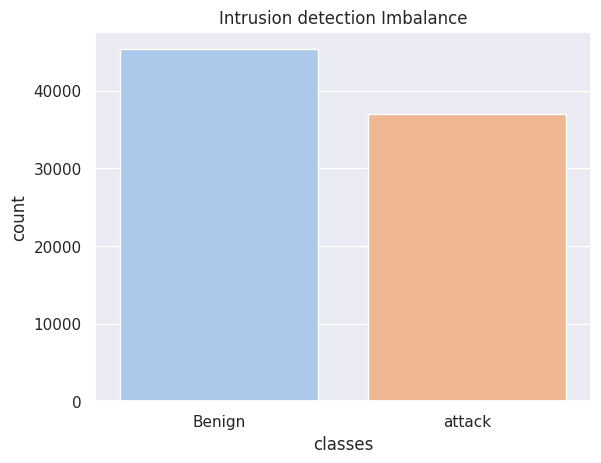

In [13]:
# Visualise to show level of class imbalance in UNSW-NB15 Dataset.
import seaborn as sns
import matplotlib.pyplot as plt
label_class= df['target'].value_counts()
sns.barplot(x=['Benign','attack',],y=label_class, palette="pastel")
plt.title("Intrusion detection Imbalance")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# Create an instance of the SMOTE class.
# smt = SMOTE()

# Apply the Synthetic over-sampling technique on the dataset (X and y).
# X_resampled, y_resampled = smt.fit_resample(X, y)

# Balance the dataset using Tomek Links.
# tl = TomekLinks(
  #   sampling_strategy='auto',
   #  n_jobs=4)

# Apply the resampling technique on the dataset (X and y).
# X_resampled, y_resampled = tl.fit_resample(X, y)

# Balance the dataset using NearMiss technique.
nm2 = NearMiss(
      sampling_strategy='auto',
      version=2)

# Apply the resampling technique on the dataset (X and y).
X_resampled, y_resampled = nm2.fit_resample(X, y)

# Balance the dataset using Random Undersampling technique.
# rus = RandomUnderSampler(sampling_strategy='auto', s
#     random_state=0,
#     replacement=True )

# Apply the resampling technique on the dataset (X and y).
# X_resampled, y_resampled = rus.fit_resample(X, y)

# Balance the dataset using Random Oversampling technique.
# ros = RandomOverSampler()

# Apply the resampling technique on the dataset (X and y).
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
# Add a new column named 'target' to the DataFrame `X_resampled`
X_resampled['target'] = y_resampled

In [ ]:
# Save DataFrame to a CSV file
X_resampled.to_csv("file1.csv")

In [ ]:
# Initiate spark session
spark = SparkSession.builder.appName("Network Attacks Classifier").master("local").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

start = time.time()

In [ ]:
# read the CSV file into a Spark DataFrame
df = spark.read.csv('file1.csv', header = True, inferSchema = True)
df.printSchema()
cols=df.columns

In [ ]:
# drop the column 'attack_cat'
df = df.drop('attack_cat')
df.show()

In [ ]:
# Assembling features and indexing the target variable
features = [f for f in df.columns if f not in ["target"]]
#result , loop, condition
df_assembler = VectorAssembler(inputCols=features, outputCol="features").setHandleInvalid("skip")
dataset = df_assembler.transform(df)
dataset.printSchema()

label_indexer = StringIndexer(inputCol="target", outputCol="label").setHandleInvalid("skip").fit(dataset)
dataset = label_indexer.transform(dataset)
dataset.printSchema()


In [ ]:
# Select distinct values from the "label" column, order them in ascending order,
# and then collect the values into a list.
label_list = dataset.select(["label"]).distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()
print(label_list)

# Select relevant columns for model training and testing
dataset = dataset.select(["features", "label"])
dataset.printSchema()

# Split the dataset into training and testing sets
train_set, test_set = dataset.randomSplit([0.75, 0.25], seed=42)
print("Training set Count: " + str(train_set.count()))
print("Test set Count: " + str(test_set.count()))



In [ ]:
# Initialize Logistic Regression model
lr = LogisticRegression()

# Initialise Decision Tree model
dt = DecisionTreeClassifier()

# Initialise Random Forest model
rf = RandomForestClassifier()

# Initialise Naive Bayes Multinomial model
nb = NaiveBayes()

# Store models in a dictionary for easier iteration
classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
                "Random Forest": rf, "Naive Bayes Multinomial": nb}
# Define evaluation metrics to be computed for each model
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

print("\nModels Evaluation:")
print("{:-<24}".format(""))


In [ ]:
# Iterate through each classifier
for idx, c in enumerate(classifiers):
    print(c)
    # Fit the model on the training data
    model = classifiers[c].fit(train_set)

    # Use the trained model to make predictions on the test data
    predictions = model.transform(test_set)
    predictions.cache()

    # Evaluate the performance of the model using PySpark's MulticlassClassificationEvaluator
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    for m in metrics:
        evaluator.setMetricName(m)
        metric = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric))

    # Build confusion matrix using Scikit-learn (sktlearn)
    target_list = predictions.select("label").rdd.flatMap(lambda x: x).collect()
    pred_list = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    label_num_list = predictions.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()
    # print("\nClassification report using Sklearn:")
    print(classification_report(target_list, pred_list))

		# Compute and visualize the confusion matrix using seaborn
    conf_matrix = confusion_matrix(target_list, pred_list)
    plt.figure(idx)
    plt.title("Confusion matrix - {model}".format(model=c))
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
                annot_kws={"size": 10}, xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()

# Display all the confusion matrix plots
plt.show()


